# Regresión Logística

**Nota: La parte de cufflinks no se visualiza correctamente en JupiterLab. Abrir en Jupyter**

Trabajaremos con el [Titanic Data Set from Kaggle] (https://www.kaggle.com/c/titanic). ¡Este es un conjunto de datos muy famoso y muy a menudo es el primer paso de un estudiante en el aprendizaje automático!

Intentaremos predecir una clasificación: supervivencia o fallecimiento.
Comencemos nuestra comprensión de la implementación de Regresión logística en Python para la clasificación.


**Diccionario de datos**


Variable|Definición|Llave
-- | --| --
PassengerId|Número de pasajero|
Survived|Supervivencia|0 = No, 1 = Sí
Pclass|Clase de entradas|1 = 1era, 2 = 2da, 3 = 3ra
Name|Nombre del pasajero|
Sex|Sexo|
Age|Edad en años|
SibSp|# de hermanos / esposas a bordo del Titanic|
Parch|# de padres / hijos a bordo del Titanic|
Ticket|Numero de ticket|
Fare|Tarifa de pasajero|
Cabin|Número de cabina|
Embarked|Puerto de embarque|C = Cherburgo, Q = Queenstown, S = Southampton

**Notas**  
pClass : Un indicador de estatus socioeconómico (SES)  
primera = Alta  
segunda = Medio  
tercera = Baja  
edad : La edad es fraccionada si es inferior a 1. Si se estima la edad, es en la forma de XX.5  
sibsp : El conjunto de datos define las relaciones familiares de esta manera ...  
Hermano = hermano, hermana, hermanastro, hermanastra  
Cónyuge = esposo, esposa (se ignoraron amantes y novios)  
parch : El conjunto de datos define las relaciones familiares de esta manera ...  
Padre = madre, padre  
Niño = hija, hijo, hijastra, hijastro  
Algunos niños viajaron solo con una niñera, por lo tanto, parch = 0 para ellos.  

## Importamos las  librerias


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Cargamos los datos

In [2]:
train = pd.read_csv('titanic_train.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## EDA (Análisis Exploratorio de Datos)


### Datos Faltantes

<Axes: >

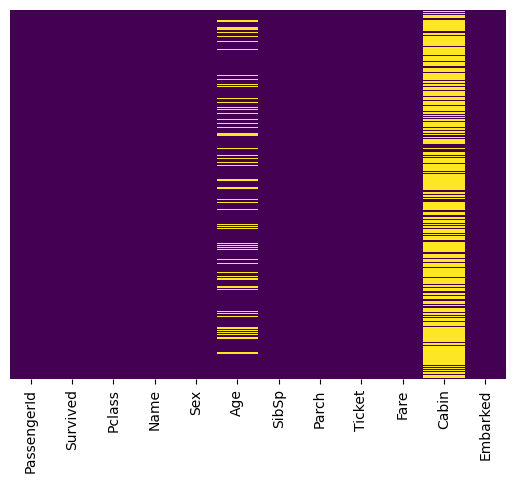

In [4]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Falta aproximadamente el 20% de los datos de edad. Es probable que la proporción de edad faltante sea lo suficientemente pequeña para un reemplazo razonable, con alguna forma de imputación. Revisando la columna Cabina, parece que nos faltan demasiados datos para hacer algo útil en un nivel básico. Probablemente dejaremos esto más adelante o lo cambiaremos a otra función como "Cabin Known: 1 or 0"

¡Continuemos visualizando más datos! 

<Axes: xlabel='Survived', ylabel='count'>

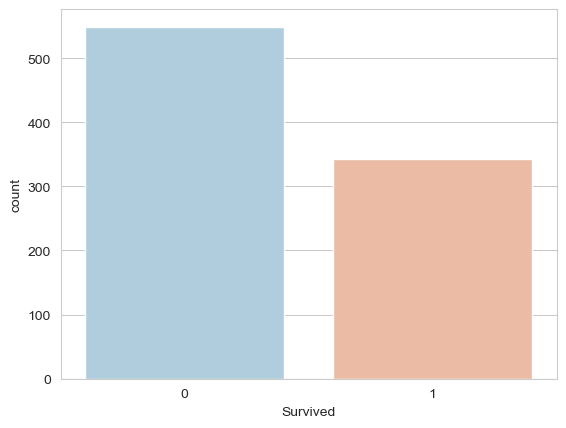

In [5]:
# Revisemos la columna de supervivencia
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

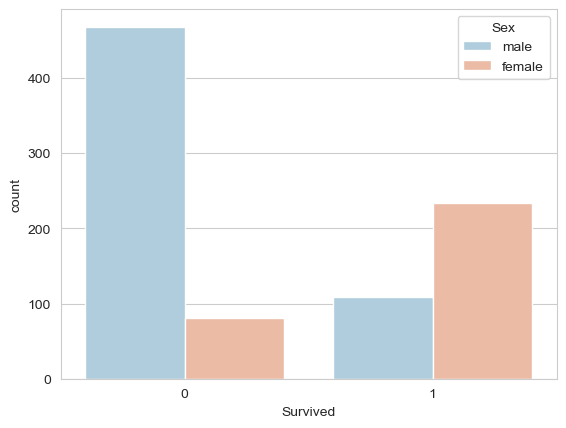

In [6]:
# Revisemos la columna de supervivencia por género
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

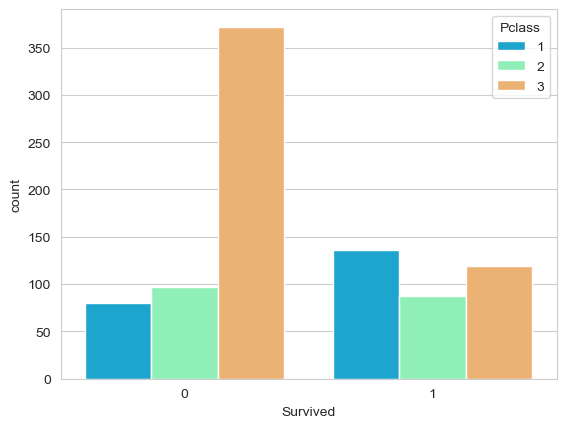

In [7]:
# Revisemos la columna de supervivencia por clase
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

<Axes: xlabel='Age', ylabel='Count'>

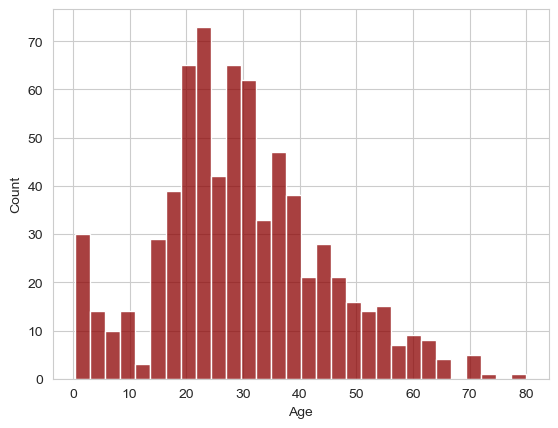

In [8]:
# Revisemos la distribución de las edades
sns.histplot(train['Age'].dropna(),kde=False,color='darkred',bins=30)

<Axes: xlabel='SibSp', ylabel='count'>

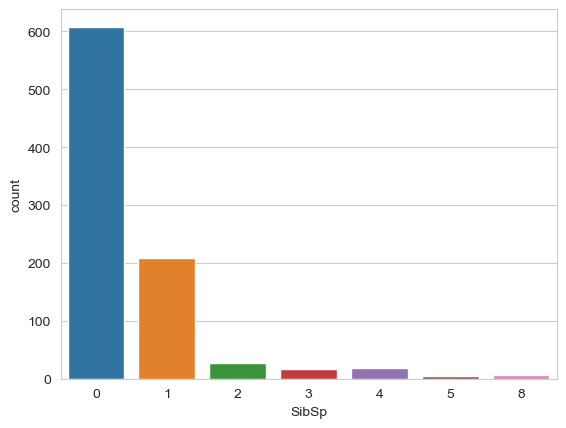

In [9]:
# Revisemos la columna de hermanos / esposos
sns.countplot(x='SibSp',data=train)

<Axes: >

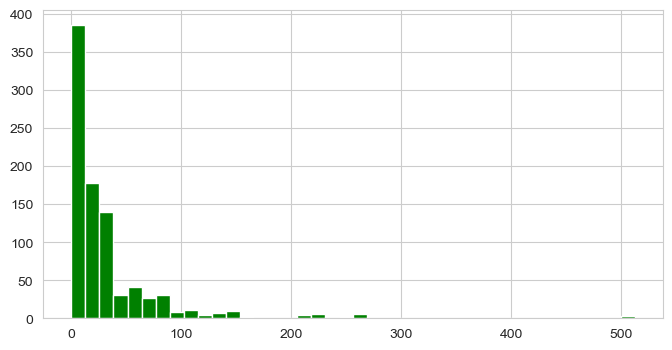

In [10]:
# Revisemos la columna de tarifas
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

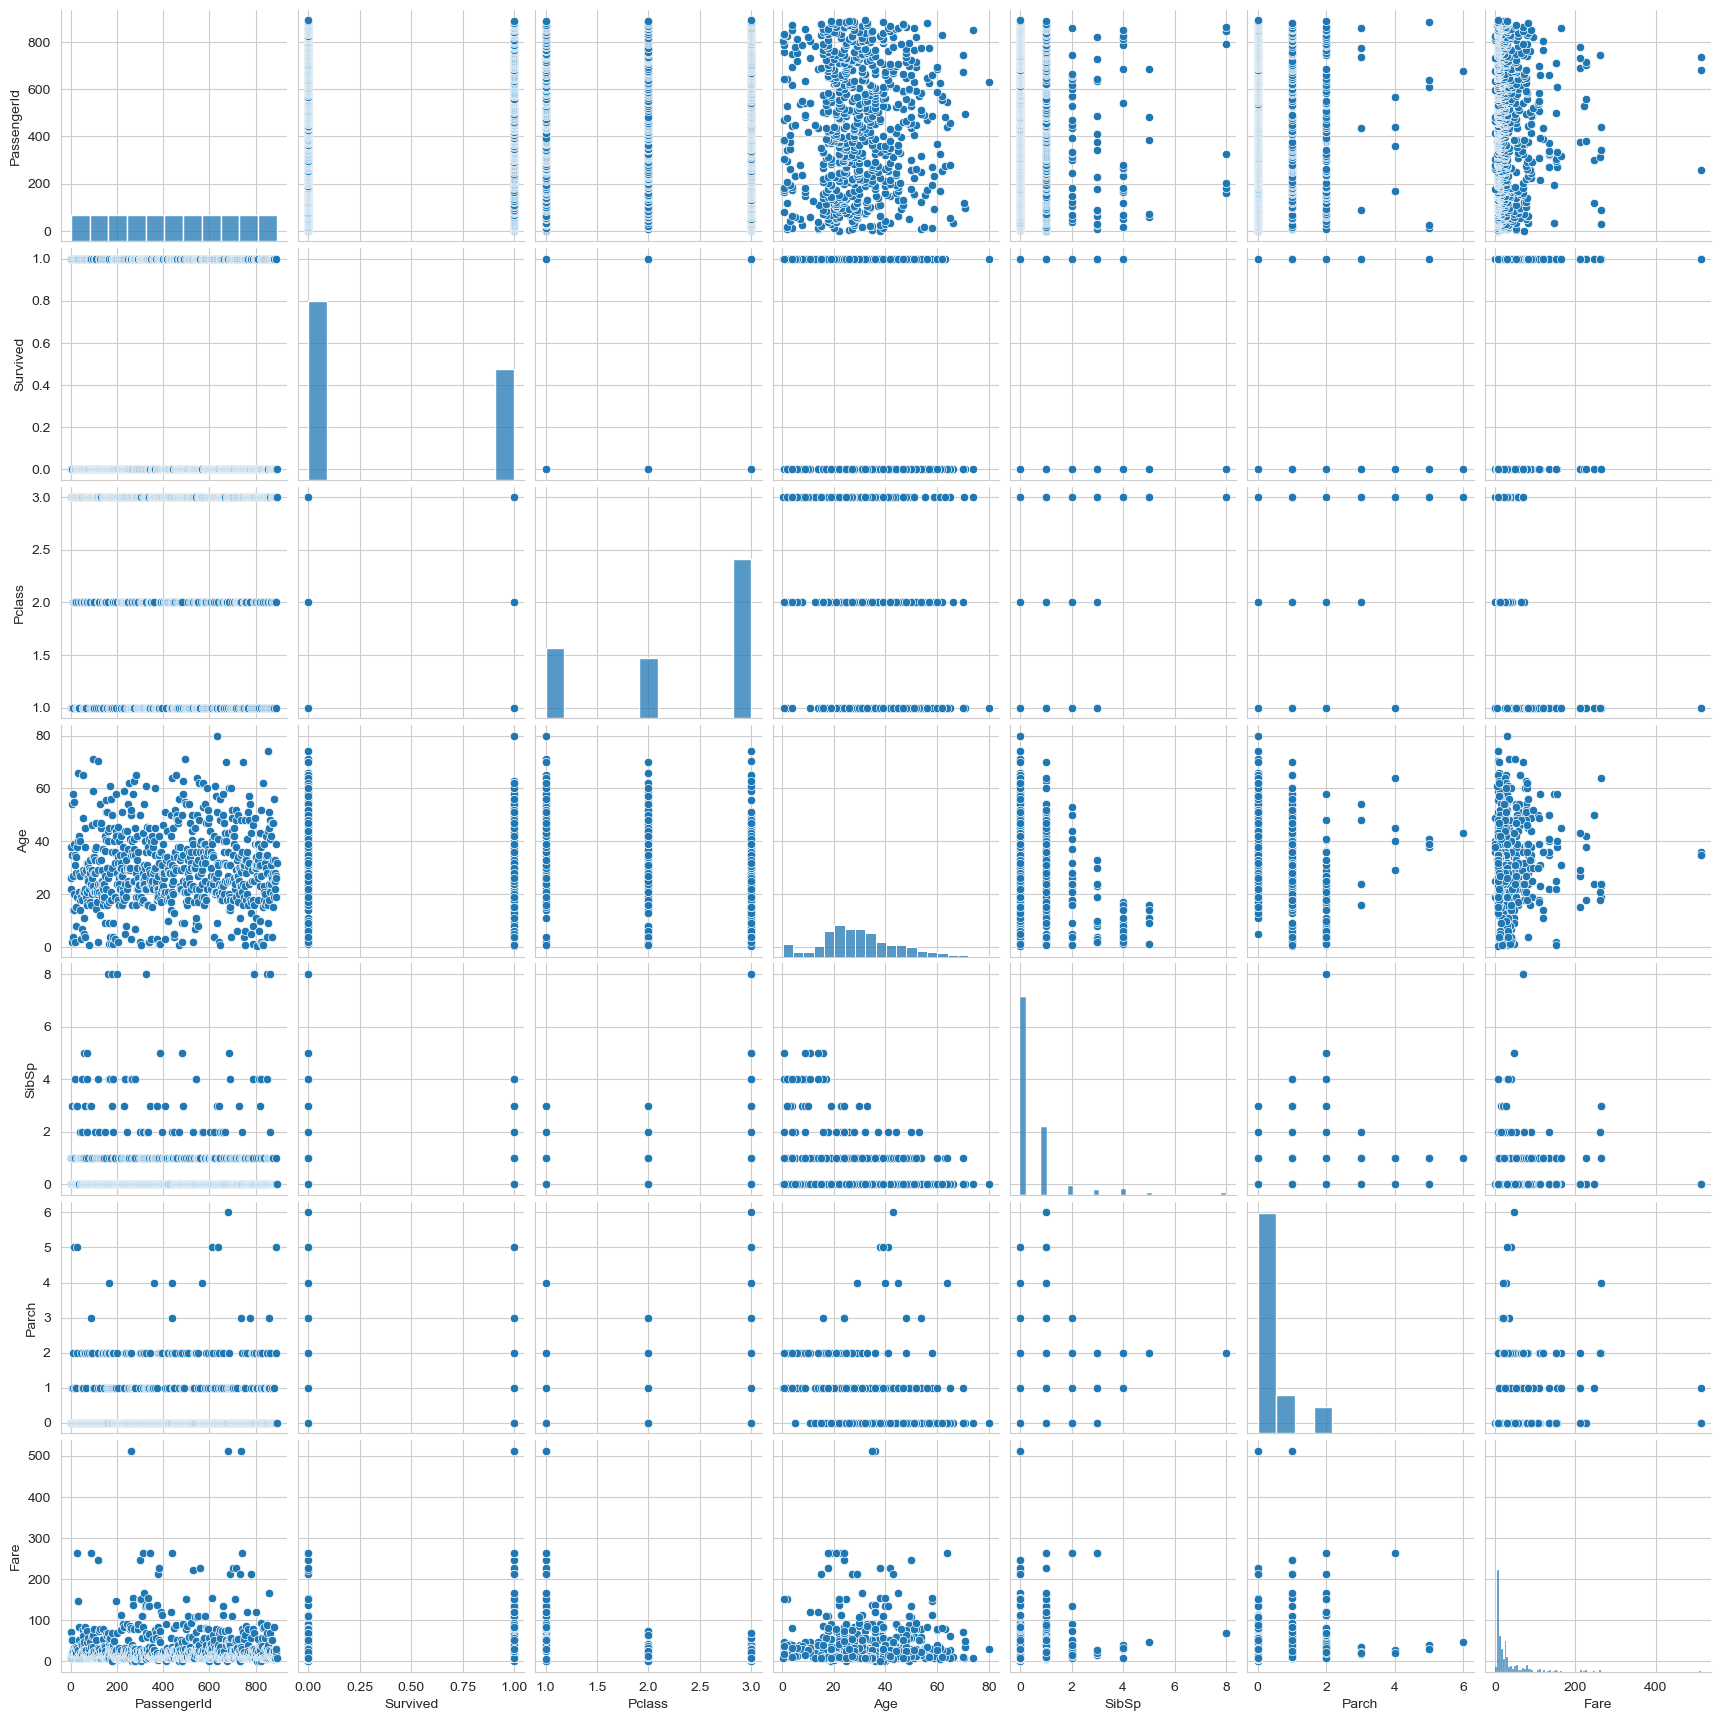

In [11]:
# Revisemos la relación entre todas las columnas
sns.pairplot(train)

____
### Cufflinks para gráficos
___
Detengámonos un momento, para mostrar un ejemplo del uso de la librería cufflinks

In [12]:
import cufflinks as cf
cf.go_offline()

C:\Users\csameshima\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning:

Blowfish has been deprecated



In [13]:
train['Fare'].iplot(kind='hist',bins=30,color='green')


## Limpieza de  datos

Completemos los datos de la edad faltantes, en lugar de simplemente borrarlos. Una forma de hacerlo es usando la edad media de todos los pasajeros (imputación).
Sin embargo, podemos ser más inteligentes al respecto y verificar la edad promedio por clase de pasajero. Por ejemplo:

<Axes: xlabel='Pclass', ylabel='Age'>

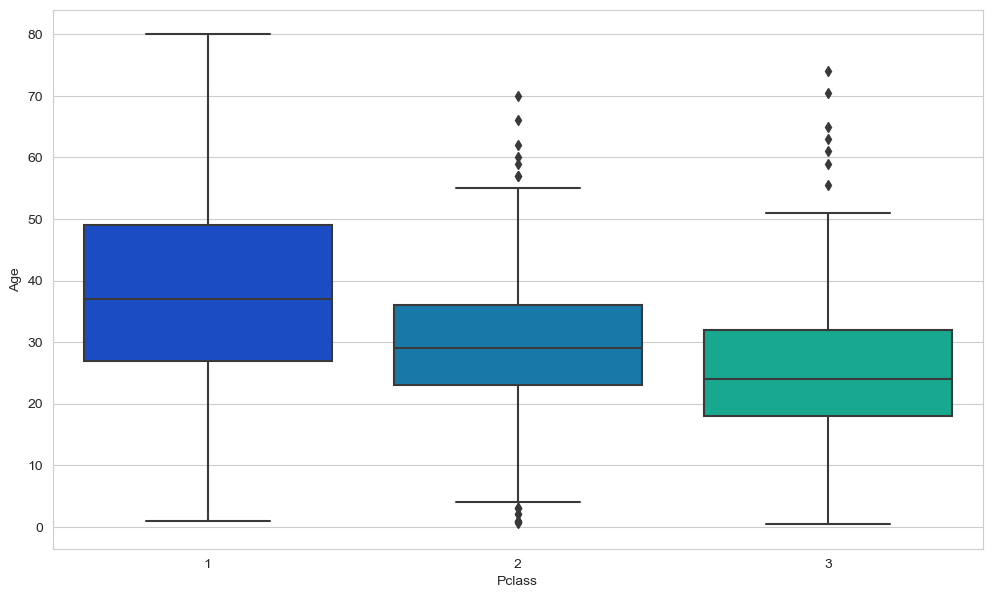

In [14]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

Podemos ver que los pasajeros más ricos en las clases altas tienden a ser mayores, lo cual tiene sentido. Utilizaremos estos valores de edad promedio para imputar según la clase.

In [15]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

Apliquemos la función

In [16]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

Revisemos de nuevo el mapa de calor

<Axes: >

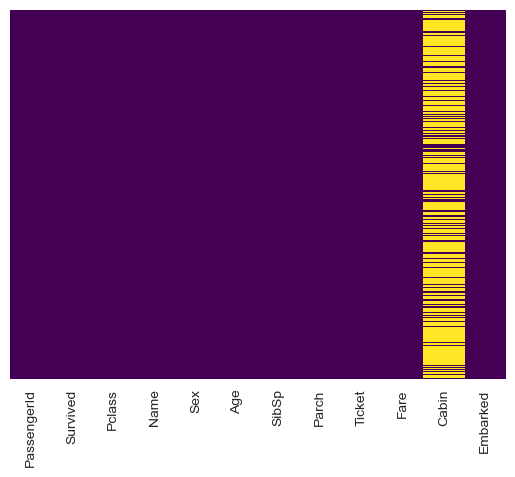

In [17]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Ahora eliminemos la columna de la cabina (Cabin) y la fila de embarque (Embarked) que tiene valor NaN

In [18]:
train.drop('Cabin',axis=1,inplace=True)

In [19]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [20]:
train.dropna(inplace=True)

<Axes: >

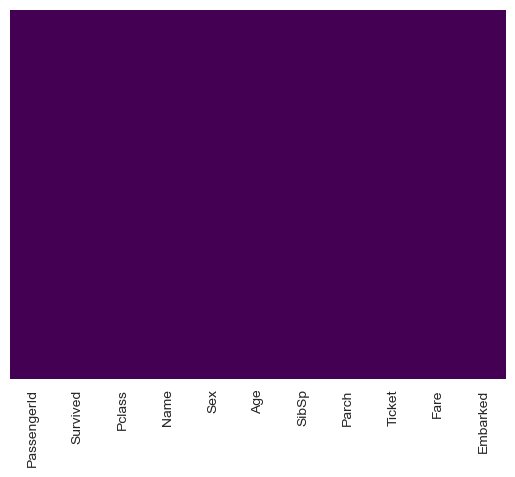

In [21]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Transformemos las características categóricas

¡Necesitaremos convertir las características categóricas en variables ficticias usando pandas! De lo contrario, nuestro algoritmo de aprendizaje automático no podrá tomar directamente esas características como entradas.

In [22]:
# Revisemos el tipo de dato de cada característica
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [23]:
# Revisemos los datos
print(train)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ... 

In [24]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [25]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [26]:
print(train)

     PassengerId  Survived  Pclass   Age  SibSp  Parch     Fare
0              1         0       3  22.0      1      0   7.2500
1              2         1       1  38.0      1      0  71.2833
2              3         1       3  26.0      0      0   7.9250
3              4         1       1  35.0      1      0  53.1000
4              5         0       3  35.0      0      0   8.0500
..           ...       ...     ...   ...    ...    ...      ...
886          887         0       2  27.0      0      0  13.0000
887          888         1       1  19.0      0      0  30.0000
888          889         0       3  24.0      1      2  23.4500
889          890         1       1  26.0      0      0  30.0000
890          891         0       3  32.0      0      0   7.7500

[889 rows x 7 columns]


In [27]:
train = pd.concat([train,sex,embark],axis=1)

In [28]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


Ahora nuestros datos estan listos para nuestro modelo

## Construyamos el modelo de Regresión Logística

Comencemos dividiendo nuestros datos en un conjunto de entrenamiento y un conjunto de prueba (hay otro archivo test.csv con el que puedes jugar, en caso de que quieras usar todos estos datos para el entrenamiento).

### Dividir el conjunto de datos en conjunto de entrenamiento y conjunto de prueba

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

### Escalado de variables

In [31]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

### Entrenar y predecir

In [32]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

In [33]:
predictions = logmodel.predict(X_test)
predictions

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1], dtype=int64)

Ahora evaluemos el modelo

### Evaluación

¡Verifiquemos la precisión, el recall y el f1-score usando el informe de clasificación!

In [34]:
from sklearn.metrics import classification_report

In [35]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       163
           1       0.84      0.68      0.75       104

    accuracy                           0.82       267
   macro avg       0.83      0.80      0.81       267
weighted avg       0.83      0.82      0.82       267



La precision es la relación entre el número de positivos verdaderos y el número de falsos positivos. La precision es la capacidad del clasificador de no etiquetar como positiva una muestra que es negativa.  

tp / (tp + fp) tpfp

El recall es la relación entre el número de positivos verdaderos y el número de falsos negativos. El recall es la capacidad del clasificador para encontrar todas las muestras positivas.  

tp / (tp + fn) tpfn

El f1-score se puede interpretar como una media armónica ponderada, de la precisión y el recall, donde un f1-score alcanza su mejor valor en 1 y el peor puntaje en 0.

El support es el número de ocurrencias de cada clase en y_true.

In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
cm

array([[149,  14],
       [ 33,  71]], dtype=int64)

¡Nuestro modelo no es tan malo! Es posible que desees explorar otra combinación de características y el otro archivo titanic_text.csv. Algunas sugerencias:

* Intenta tomar el Título (Dr., Sr., Sra., etc.) del nombre como una característica
* Tal vez la letra de la cabina podría ser una característica
* ¿Hay alguna información que pueda obtener del boleto?